In [2]:
import os

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import supervision as sv
from supervision.draw.color import ColorPalette

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.float16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


using device: cuda


In [3]:
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from torchvision.ops import box_convert

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"


def load_models(
    dino_id="IDEA-Research/grounding-dino-base", sam2_id="facebook/sam2-hiera-large"
):
    mask_predictor = SAM2ImagePredictor.from_pretrained(sam2_id, device=device)
    grounding_processor = AutoProcessor.from_pretrained(dino_id)
    grounding_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_id).to(
        device
    )

    return mask_predictor, grounding_processor, grounding_model


mask_predictor, grounding_processor, grounding_model = load_models()

In [4]:


with open("objects.txt", "r") as file:
    object_list = [line.strip() for line in file.readlines()]

text_prompt = ". ".join(object_list) + "."
text_prompt

'chair. table. trashbin. bed. toilet. guitar. bicycle. bag. sofa. refrigerator. washbasin. tv. lamp. microwave. toaster. coffee machine.'

In [5]:
from tqdm import tqdm
import pathlib
import cv2

from bytetrack.byte_tracker import BYTETracker

from types import SimpleNamespace

In [6]:
# args for BYTETracker
args = SimpleNamespace(
    **{
        "track_thresh": 0.3,
        "track_buffer": 90,
        "match_thresh": 0.85,
        "mot20": False,
        "min_box_area": 100,
    }
)

(np.float64(-0.5), np.float64(1295.5), np.float64(967.5), np.float64(-0.5))

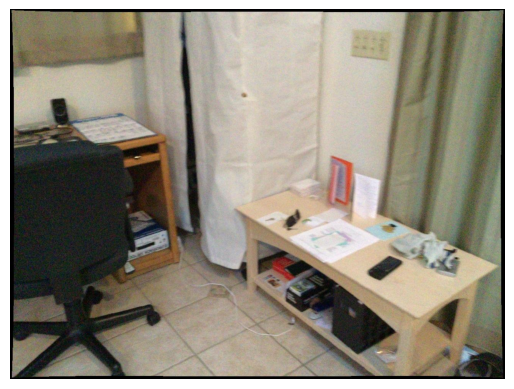

In [7]:
img_dir = "/home/chadwick/Downloads/color"
img_dir = pathlib.Path(img_dir)
img_paths = list(img_dir.glob("*.*"))
img_paths = sorted(img_paths, key=lambda x: int(x.stem))

# draw the first image
img = cv2.imread(str(img_paths[0]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

In [8]:
tracker = BYTETracker(args)

In [9]:
paused = False

for img_path in tqdm(img_paths, desc="Processing images"):
    while paused:  # If paused, wait here until resumed
        key = cv2.waitKey(1) & 0xFF
        if key == ord(" "):  # Press Space to resume
            paused = False
            print("Resuming processing...")
        elif key == ord("q"):  # Press 'q' to exit
            print("Exiting program...")
            cv2.destroyAllWindows()
            exit()

    image = Image.open(img_path)
    image = np.array(image.convert("RGB"))

    inputs = grounding_processor(
        images=image,
        text=text_prompt,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = grounding_model(**inputs)

    results = grounding_processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.35,
        text_threshold=0.35,
        target_sizes=[image.shape[:2]],
    )

    class_names = np.array(results[0]["labels"])
    input_boxes = results[0]["boxes"].cpu().numpy()  # (n_boxes, 4)
    confidences = results[0]["scores"].cpu().numpy()  # (n_boxes,)
    detection_data = np.hstack((input_boxes, confidences.reshape(-1, 1)))

    class_ids = np.array(list(range(len(class_names))))

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence in zip(class_names, confidences)
    ]
    # import ipdb; ipdb.set_trace()

    online_targets = tracker.update(detection_data, class_names)
    online_tlwhs = []
    online_tlbrs = []
    onlin_orig_bboxes = []
    online_ids = []
    online_scores = []
    online_class_names = []

    for t in online_targets:
        tlwh = t.tlwh
        tlbr = t.tlbr
        tid = t.track_id
        if tlwh[2] * tlwh[3] > args.min_box_area:
            online_tlwhs.append(tlwh)
            onlin_orig_bboxes.append(t.curr_bbox)
            online_tlbrs.append(tlbr)
            online_ids.append(tid)
            online_scores.append(t.score)
            online_class_names.append(t.class_name)

    # sam2
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        mask_predictor.set_image(image)

        if len(onlin_orig_bboxes) > 0:
            online_masks, _, _ = mask_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=np.array(onlin_orig_bboxes),
                multimask_output=False,
            )

            if online_masks.ndim == 4:
                online_masks = online_masks.squeeze(1)

            class_ids = np.array(list(range(len(online_class_names))))

    if len(online_ids) > 0:
        detections = sv.Detections(
            xyxy=np.array(onlin_orig_bboxes),
            mask=online_masks.astype(bool),
            class_id=class_ids,
        )
        box_annotator = sv.BoxAnnotator(color=ColorPalette.DEFAULT)
        annotated_frame = box_annotator.annotate(
            scene=image.copy(), detections=detections
        )

        labels = [
            f"{class_name} {id} {confidence:.2f}"
            for class_name, id, confidence in zip(
                online_class_names, online_ids, online_scores
            )
        ]
        label_annotator = sv.LabelAnnotator(
            color=ColorPalette.DEFAULT,
            text_padding=4,
            text_scale=0.3,
            text_position=sv.Position.TOP_LEFT,
            color_lookup=sv.ColorLookup.INDEX,
            # smart_position=True,
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        mask_annotator = sv.MaskAnnotator(color=ColorPalette.DEFAULT)
        annotated_frame = mask_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
    else:
        annotated_frame = image.copy()

    final_frame = annotated_frame
    cv2.putText(
        final_frame,
        f"{img_path.stem}.png",
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        1,
    )
    final_frame = cv2.cvtColor(final_frame, cv2.COLOR_RGB2BGR)
    cv2.imshow("Annotated Frame", final_frame)

    # Handle key inputs
    key = cv2.waitKey(0 if paused else 1) & 0xFF  # If paused, wait for input
    if key == ord("q"):  # Press 'q' to quit
        print("Exiting program...")
        break
    elif key == ord(" "):  # Press Space to pause
        paused = True
    print("Paused. Press Space to resume...")

    # save annotated frame, numpy array h x w x 3
    # try:
    #     img_dir = pathlib.Path("/home/chadwick/Downloads/extracted/image_s")
    #     img_dir.mkdir(exist_ok=True)
    #     Image.fromarray(final_frame).save(img_dir / f"{img_path.stem}.png")
    # except Exception as e:
    #     print(f"Error saving image: {e}")

    # # save class_names, input_boxes, masks, and confidences into npz file
    # npz_dir = pathlib.Path("/home/chadwick/Downloads/cic_1217_npz")
    # npz_dir.mkdir(exist_ok=True)
    # np.savez_compressed(
    #     npz_dir / f"{img_path.stem}.npz",
    #     labels=np.array(online_class_names),
    #     bboxes=np.array(onlin_orig_bboxes),
    #     masks=online_masks,
    #     confidences=np.array(online_scores),
    #     ids=np.array(online_ids),
    # )


Processing images:   0%|          | 1/5578 [00:00<1:19:31,  1.17it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 2/5578 [00:01<48:31,  1.92it/s]  

Paused. Press Space to resume...


Processing images:   0%|          | 3/5578 [00:01<37:08,  2.50it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 4/5578 [00:01<31:55,  2.91it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 5/5578 [00:01<28:48,  3.22it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 6/5578 [00:02<27:07,  3.42it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 7/5578 [00:02<26:10,  3.55it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 8/5578 [00:02<30:21,  3.06it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 9/5578 [00:03<29:01,  3.20it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 10/5578 [00:03<27:14,  3.41it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 11/5578 [00:03<25:53,  3.58it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 12/5578 [00:03<25:19,  3.66it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 13/5578 [00:04<24:54,  3.72it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 14/5578 [00:04<24:21,  3.81it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 15/5578 [00:04<24:26,  3.79it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 16/5578 [00:04<24:07,  3.84it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 17/5578 [00:05<23:53,  3.88it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 18/5578 [00:05<23:55,  3.87it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 19/5578 [00:05<23:54,  3.87it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 20/5578 [00:05<23:46,  3.90it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 21/5578 [00:06<23:55,  3.87it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 22/5578 [00:06<23:40,  3.91it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 23/5578 [00:06<23:19,  3.97it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 24/5578 [00:06<23:16,  3.98it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 25/5578 [00:07<23:11,  3.99it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 26/5578 [00:07<23:07,  4.00it/s]

Paused. Press Space to resume...


Processing images:   0%|          | 27/5578 [00:07<23:13,  3.98it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 28/5578 [00:07<23:25,  3.95it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 29/5578 [00:08<23:15,  3.98it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 30/5578 [00:08<22:57,  4.03it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 31/5578 [00:08<23:00,  4.02it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 32/5578 [00:08<23:04,  4.01it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 33/5578 [00:09<23:01,  4.01it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 34/5578 [00:09<22:58,  4.02it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 35/5578 [00:09<23:03,  4.01it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 36/5578 [00:09<23:02,  4.01it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 37/5578 [00:10<23:01,  4.01it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 38/5578 [00:10<23:25,  3.94it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 39/5578 [00:10<23:20,  3.96it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 40/5578 [00:10<23:42,  3.89it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 41/5578 [00:11<23:41,  3.90it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 42/5578 [00:11<23:24,  3.94it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 43/5578 [00:11<23:31,  3.92it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 44/5578 [00:11<23:38,  3.90it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 45/5578 [00:12<23:19,  3.95it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 46/5578 [00:12<23:30,  3.92it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 47/5578 [00:12<23:33,  3.91it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 48/5578 [00:13<24:13,  3.81it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 49/5578 [00:13<24:20,  3.79it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 50/5578 [00:13<23:57,  3.85it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 51/5578 [00:13<23:28,  3.93it/s]

Paused. Press Space to resume...


Processing images:   1%|          | 51/5578 [00:14<25:20,  3.63it/s]

Exiting program...


: 